# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
# загрузим все необходимые в проекте библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

### Откроем файлы и сохраним датафреймы 

In [2]:
df_region_one = pd.read_csv('/datasets/geo_data_0.csv')
df_region_two = pd.read_csv('/datasets/geo_data_1.csv')
df_region_three = pd.read_csv('/datasets/geo_data_2.csv')

# выведем первые 5 строк всех трех датафреймов
display(df_region_one.sample(5), df_region_two.sample(5), df_region_three.sample(5))

id        f0        f1        f2     product
10257  7yDVq  2.183409  0.501315  1.159307   48.941681
30258  0Tmda  0.520446  0.977443  7.685514  159.400902
7002   Wu18f  1.397973 -0.396121 -2.123795   65.055570
88050  BWAPd -0.211316  1.025175  1.186738  101.164322
76404  hcS22  0.900717  0.208142  8.360422  147.964568

id         f0        f1        f2     product
51111  mViLe  -7.355916 -3.727993  2.998838   84.038886
24284  45rd3  -5.667375 -3.126255  0.994082   30.132364
18626  gkeQA  16.100497  4.856885  5.002200  134.766305
26017  Cy9eR -11.723577 -0.037984  3.005272   84.038886
3057   ClinZ  -6.192943  0.799577  3.002010   84.038886

id        f0        f1        f2     product
59983  pV6cn -2.668256  2.923109  7.589204  177.200005
22967  u9Zcy -0.496343 -0.647353  2.052723   77.258001
34803  7KjFL -0.753743  0.879979  5.556156  115.647981
2372   R97uY -0.449116 -1.239341  2.231322   37.044402
25137  PuIJ3  0.068088  2.201550  4.429242  153.721700

### Исследуем данные

 Выведем основную информацию для всех трех датафреймов с помощью метода `info()`

In [3]:
df_region_one.info(), df_region_one.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


(None,
 id         0
 f0         0
 f1         0
 f2         0
 product    0
 dtype: int64)

In [4]:
df_region_two.info(), df_region_two.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


(None,
 id         0
 f0         0
 f1         0
 f2         0
 product    0
 dtype: int64)

In [5]:
df_region_three.info(), df_region_three.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


(None,
 id         0
 f0         0
 f1         0
 f2         0
 product    0
 dtype: int64)

Пропусков в данных нет, все **признаки количественные** и имеют соответсвующий тип данных.
В каждом датафрейме по **10000 объетов (скважин)** и **5 признаков**, включая *идентификационный номер скважины*.

Проверим количественные признаки на отсутствие/присутствие аномалий в данных.

In [6]:
df_region_one.describe()

f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347

In [7]:
df_region_two.describe()

f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.734063       5.019721     137.945408

In [8]:
df_region_three.describe()

f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.844801      16.739402     190.029838

Из общей статистической информации по трем регионам можно сказать:

- *во втором регионе* наблюдаются более широкие пределы значений (**min**, **max**) признаков `['f0']` и `['f1']` и более узкие по признаку `['f2']` (**df_region_two**). Так как значения признаков неизвестны, сложно сказать о наличии выбросов в данных. Скорее всего такие значения указывают на значимое различие второго региона по этим признакам в сравнении с другими;
- *во втором регионе* **объём запасов** в большей части скважин (значения **mean** и **max**) намного **ниже**.

### Проверка на наличие дубликатов

Перед дальнейшим исследованием необходимо обязательно устранить явные и неявные дубликаты в данных.

Сначала проверим есть ли в данных явные дубликаты.

In [9]:
df_region_one.duplicated().sum()

0

In [10]:
df_region_two.duplicated().sum()

0

In [11]:
df_region_three.duplicated().sum()

0

Явных дубликатов **не обнаружено**.

Далее проверим признаки со строковыми значениями на наличие неявных дубликатов. Такой признак только один - `['id']`.

In [12]:
df_region_one.id.value_counts()

A5aEY    2
bsk9y    2
74z30    2
AGS9W    2
Tdehs    2
        ..
1WORL    1
tpLqQ    1
4Rccs    1
du3TH    1
OCRkF    1
Name: id, Length: 99990, dtype: int64

In [13]:
df_region_two.id.value_counts()

bfPNe    2
wt4Uk    2
LHZR0    2
5ltQ6    2
Mkxtx    1
        ..
ZsWJ1    1
dMNVD    1
Sasya    1
RIUOu    1
58PtZ    1
Name: id, Length: 99996, dtype: int64

In [14]:
df_region_three.id.value_counts()

KUPhW    2
xCHr8    2
VF7Jo    2
Vcm5J    2
MuHFi    1
        ..
97AeD    1
46LMh    1
gLpnT    1
6XNtb    1
lbCnK    1
Name: id, Length: 99996, dtype: int64

Неявные дубликаты по признаку `['id']` присутствуют во всех данных в небольшом количестве. Так как по колонке `['id']` представлены не совсем номера скважин, а скорее метки для определенной точки входа в пласт, то говорить что неявные дубликаты являются по сути своей многозабойными скважинами нельзя. Поэтому необходимо удалить такие дубликаты, как возможно более старые данные по скважинам.

In [15]:
df_region_one.drop_duplicates(subset='id', keep='first', inplace=True)
df_region_two.drop_duplicates(subset='id', keep='first', inplace=True)
df_region_three.drop_duplicates(subset='id', keep='first', inplace=True)

In [16]:
# проверим удаление неявных дубликатов на примере первого датасета
df_region_one.id.value_counts()

VF36l    1
vrr6C    1
4PwYN    1
941ug    1
acdLW    1
        ..
tpLqQ    1
4Rccs    1
du3TH    1
ov4ms    1
OCRkF    1
Name: id, Length: 99990, dtype: int64

Неявные **дубликаты удалены**.

### Построение графиков распределения

Перед началом обучения моделей построим графики распредления количественных признаков по всем трем регионам.

<Figure size 1080x648 with 0 Axes>

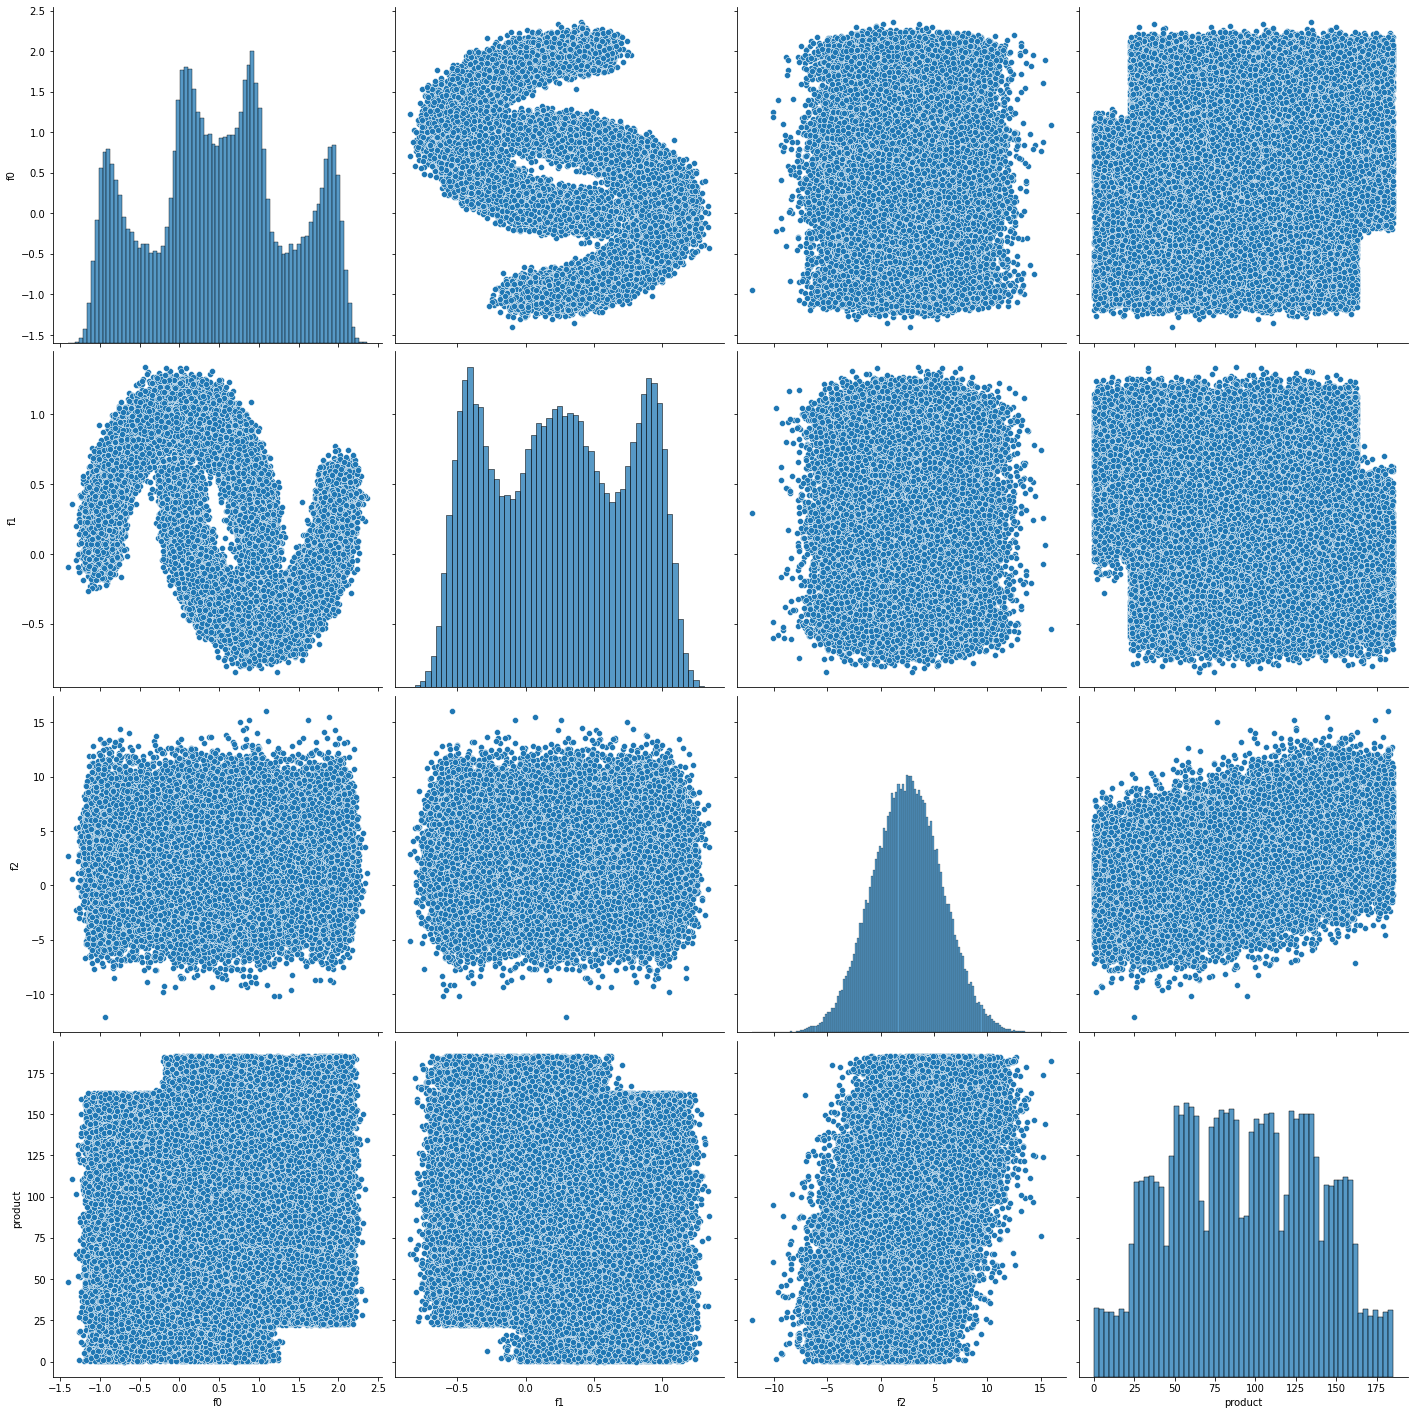

In [17]:
plt.figure(figsize=(15, 9))
sns.pairplot(df_region_one, height=5);

In [18]:
df_region_one.corrwith(df_region_one['product'])

f0         0.143504
f1        -0.192351
f2         0.483631
product    1.000000
dtype: float64

**Наблюдения:**

- только признак `['f2']` имеет нормальное распределение. Остальные признаки имеют несколько пиков в значениях;
- целевой признак `['product']` имеет определенную (видимую) положительную корреляцию с признаком `['f2']`;
- при определенных граничных значениях признаков `['f0']` и `['f1']` диапазон значений целевого признака `['product']` сдвигается;
- признаки `['f0']` и `['f1']` имеют интересную взаимную зависимость. Возможно это может говорить о синтетичности данных.

<Figure size 1080x648 with 0 Axes>

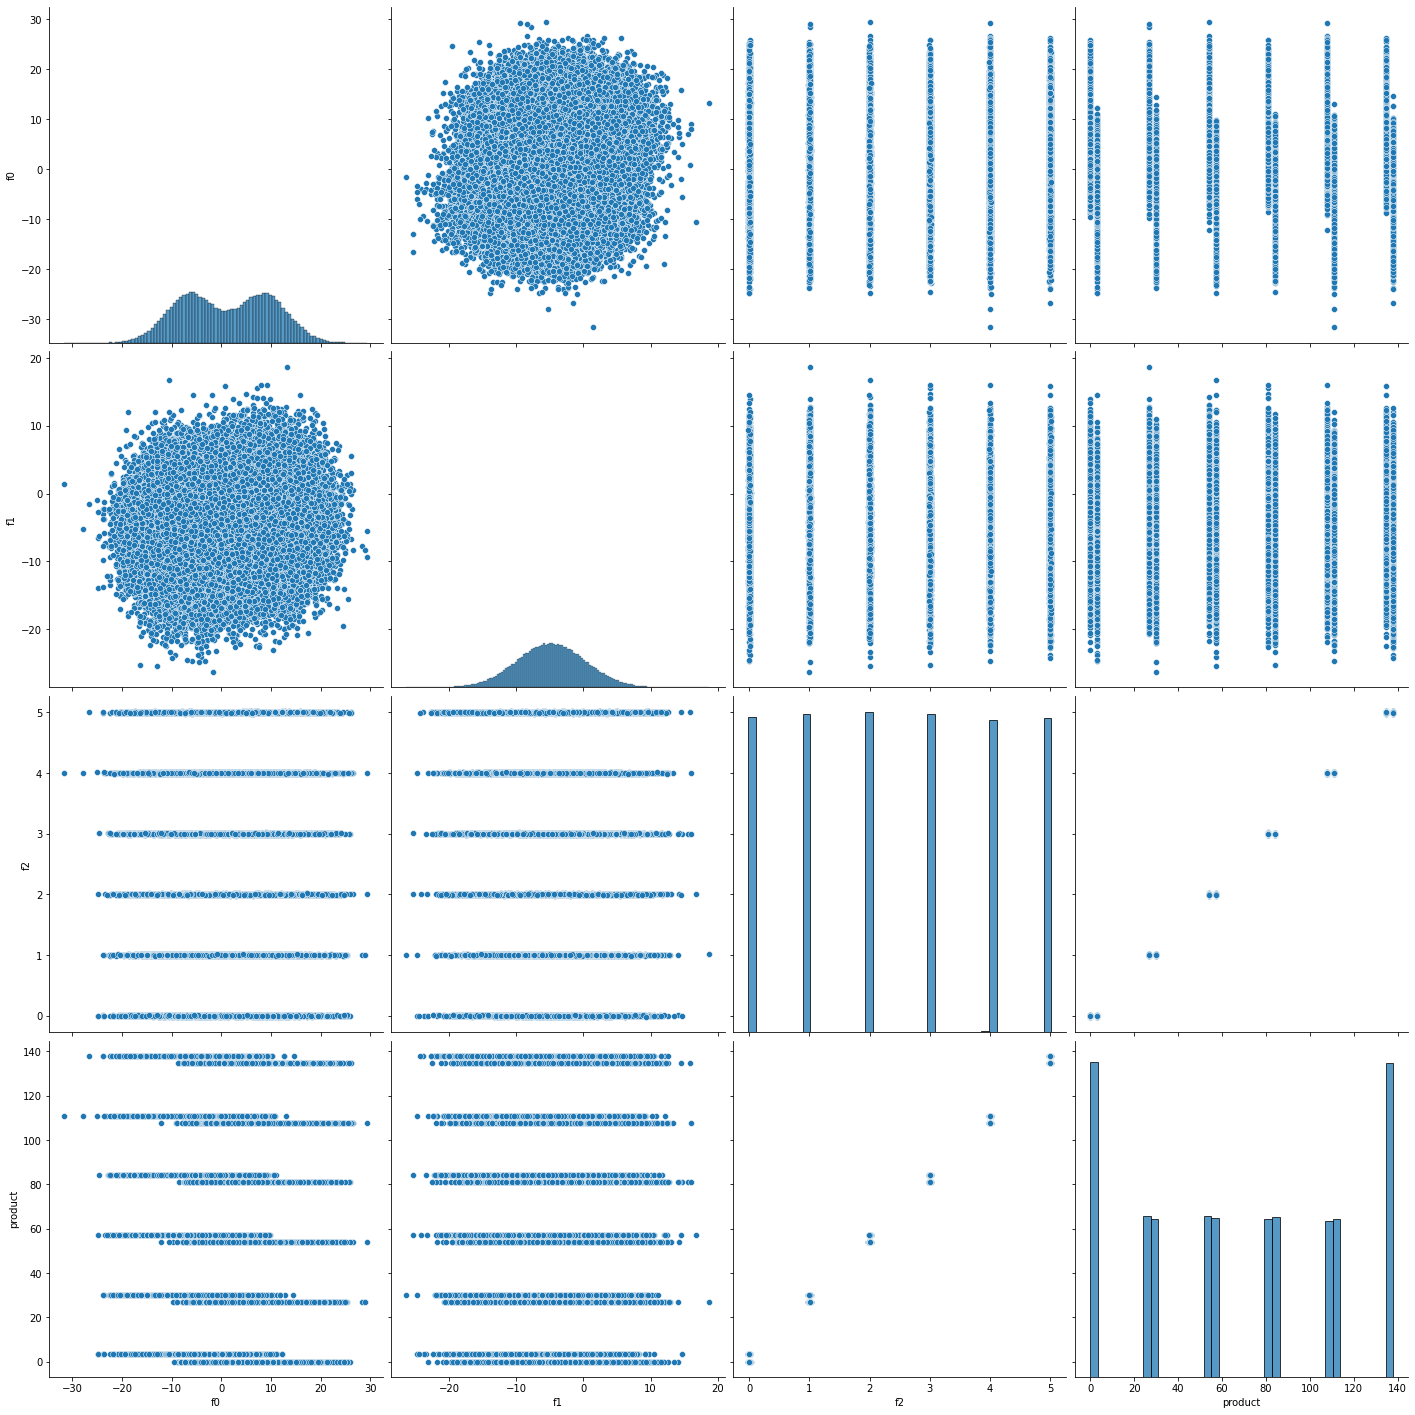

In [19]:
plt.figure(figsize=(15, 9))
sns.pairplot(df_region_two, height=5);

In [20]:
df_region_two.corrwith(df_region_two['product'])

f0        -0.030523
f1        -0.010154
f2         0.999397
product    1.000000
dtype: float64

**Наблюдения:**

- графики распределения по второму региону значительно различаются с остальными регионами, что ещё раз может подтверждать синтетическое происхождение данных;
- только признак `['f1']` имеет нормальное распределение. Признак `['f0']` имеет два пиков в значениях; 
- все 
- целевой признак `['product']` имеет строго линейную положительную связь с признаком `['f2']`;
- имеется два пиковых значения признака `['product']` около **0** и **140**.

<Figure size 1080x648 with 0 Axes>

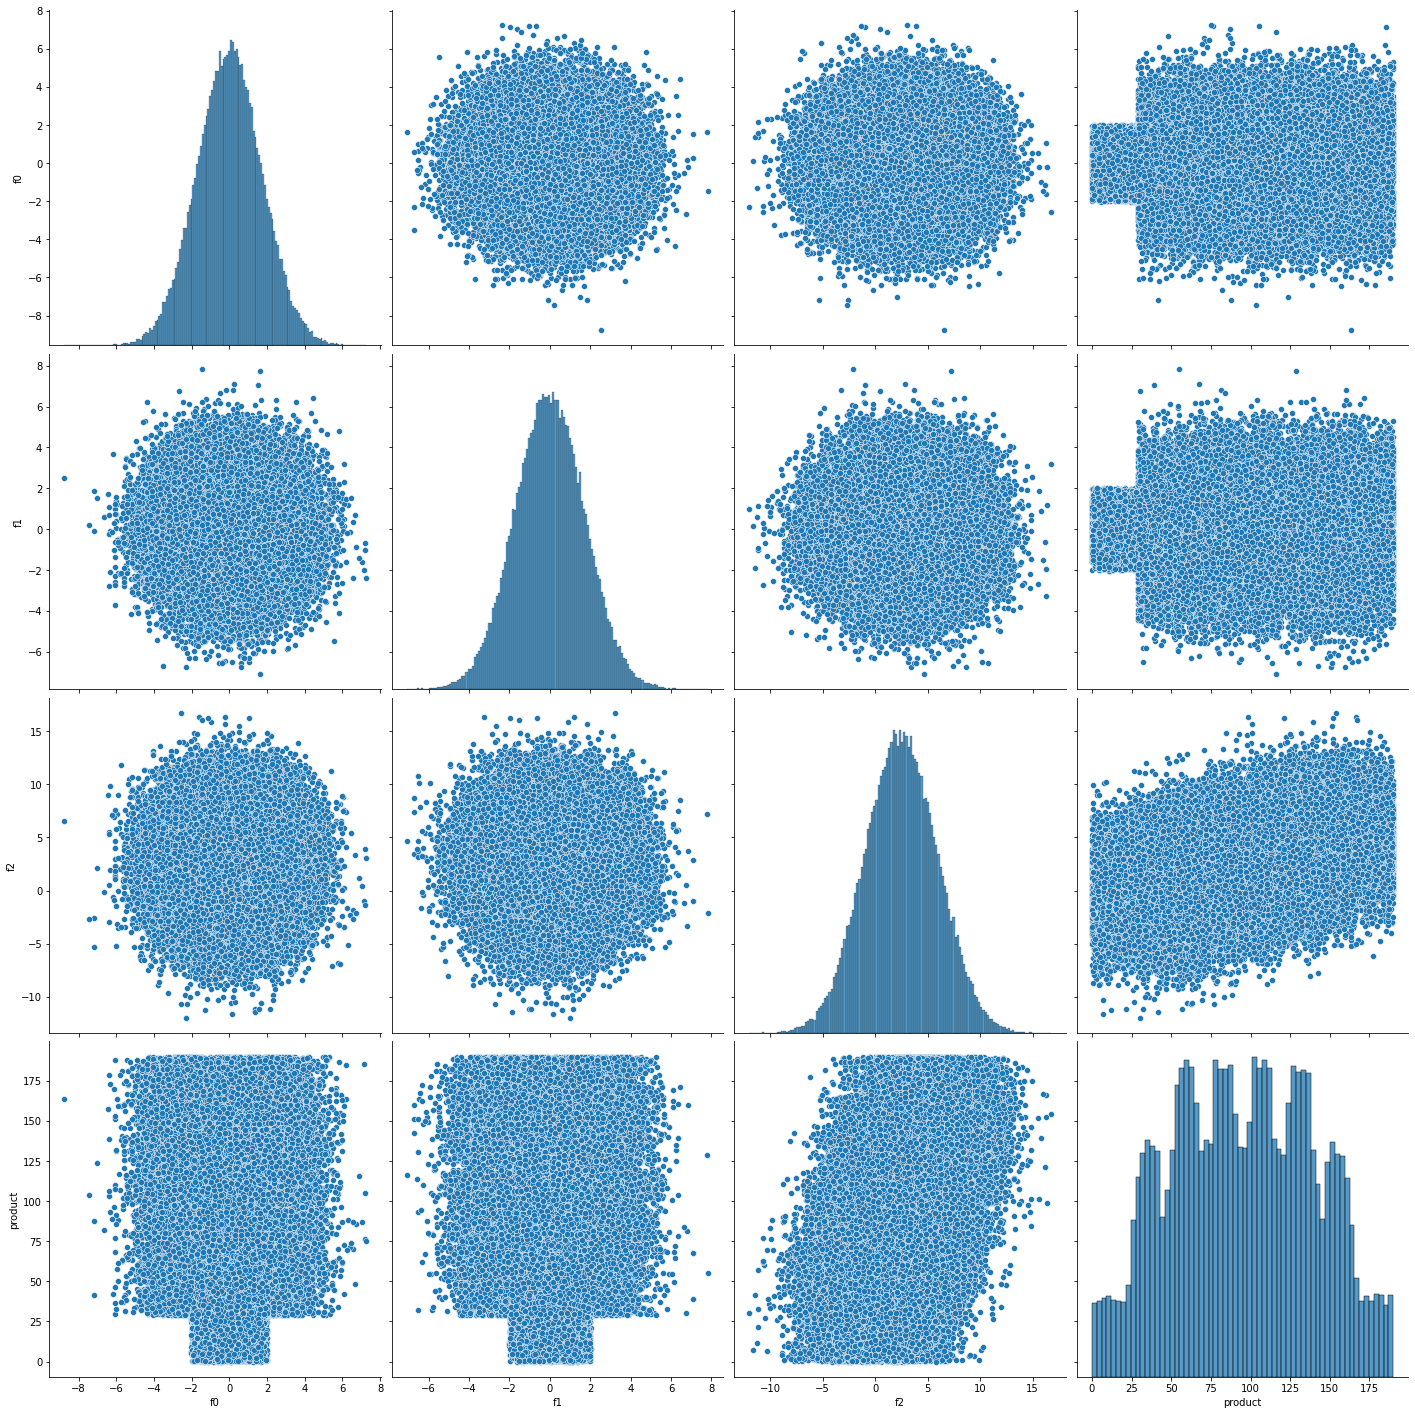

In [21]:
plt.figure(figsize=(15, 9))
sns.pairplot(df_region_three, height=5);

In [22]:
df_region_three.corrwith(df_region_three['product'])

f0        -0.001978
f1        -0.001055
f2         0.445867
product    1.000000
dtype: float64

**Наблюдения:**

- все признаки кроме `['product']` имеют нормальное распределение. Целевой признак имеет несколько пиков в значениях;
- целевой признак `['product']` имеет определенную (видимую) положительную корреляцию с признаком `['f2']`;
- при определенных значениях признаков `['f0']` и `['f1']` диапазон значений целевого признака `['product']` ступенчато изменяется;
- признаки `['f0']`,`['f1']` и `['f2']` не имеют какую-либо взаимную зависимость. 

## Обучение и проверка модели


Перед обучением модели зададим константу для объекта **RandomState**.

In [23]:
RAND_ST = np.random.RandomState(123)

### Разбивка данных на выборки

Подготовим данные для обучения модели:

1)  Отдельно определим данные с целевым признаком `['product']` и c остальными признаками. Так же исключим из данных признак `['id']`, как не имеющий важности в предсказании модели.

In [24]:
# разбивка первого региона
features_one_region = df_region_one.drop(['id', 'product'], axis=1)
# разбивка второго региона
features_two_region = df_region_two.drop(['id', 'product'], axis=1)
# разбивка третьего региона
features_three_region = df_region_three.drop(['id', 'product'], axis=1)

target_one_region = df_region_one['product']
target_two_region = df_region_two['product']
target_three_region = df_region_three['product']

2) Разобъем данные на обучающую и валидационную выборки в соотношении 75:25.

In [25]:
# разбивка первого региона
features_one_train, features_one_valid, target_one_train, target_one_valid = train_test_split(
    features_one_region, target_one_region, test_size=.25, random_state=RAND_ST 
)
# разбивка второго региона
features_two_train, features_two_valid, target_two_train, target_two_valid = train_test_split(
    features_two_region, target_two_region, test_size=.25, random_state=RAND_ST 
)
# разбивка третьего региона
features_three_train, features_three_valid, target_three_train, target_three_valid = train_test_split(
    features_three_region, target_three_region, test_size=.25, random_state=RAND_ST 
)
# выведем размеры выборок
display('Размер обучающей и валидационной выборки первого региона:')
display(features_one_train.shape, target_one_train.shape, features_one_valid.shape, target_one_valid.shape)
display('Размер обучающей и валидационной выборки второго региона:')
display(features_two_train.shape, target_two_train.shape, features_two_valid.shape, target_two_valid.shape)
display('Размер обучающей и валидационной выборки третьего региона:')
display(features_three_train.shape, target_three_train.shape, features_three_valid.shape, target_three_valid.shape)

'Размер обучающей и валидационной выборки первого региона:'

(74992, 3)

(74992,)

(24998, 3)

(24998,)

'Размер обучающей и валидационной выборки второго региона:'

(74997, 3)

(74997,)

(24999, 3)

(24999,)

'Размер обучающей и валидационной выборки третьего региона:'

(74997, 3)

(74997,)

(24999, 3)

(24999,)

3) Приведем все признаки, кроме целевого к одному масштабу с помощбю **StandardScaler**.

In [26]:
# напишем общую функцию для масштабирования данных
def features_scale(feat_train, feat_valid):
    scaler = StandardScaler()
    scaler.fit(feat_train)
    feat_train_scale = scaler.transform(feat_train)
    feat_valid_scale = scaler.transform(feat_valid)
    return feat_train_scale, feat_valid_scale

In [27]:
# масштабируем признаки первого региона
features_one_train, features_one_valid = features_scale(features_one_train, features_one_valid)
# масштабируем признаки второго региона
features_two_train, features_two_valid = features_scale(features_two_train, features_two_valid)
# масштабируем признаки третьего региона
features_three_train, features_three_valid = features_scale(features_three_train, features_three_valid)

### Обучение модели 

Для предсказания объема запасов нефти будет использована *модель линейной регрессии*. 

In [28]:
# зададим функцию для обучения модели и формирования общей сводной таблицы
def lr_model_predict(feat_train, feat_valid, targ_train, targ_valid): 
    lrmodel = LinearRegression()
    lrmodel.fit(feat_train, targ_train)
    predict = lrmodel.predict(feat_valid)
    # display(list(zip(features_one_region.columns, lrmodel.coef_)))
    return pd.DataFrame({'Target':targ_valid, 'Predict':predict})

# обучим модели и запишем данные по каждому региону
predict_one = lr_model_predict(features_one_train, features_one_valid, target_one_train, target_one_valid)
predict_two = lr_model_predict(features_two_train, features_two_valid, target_two_train, target_two_valid)
predict_three = lr_model_predict(features_three_train, features_three_valid, target_three_train, target_three_valid)

# сформируем общую сводную таблицу
# создадим датафрейм для заполнения
df_total = pd.DataFrame(
    columns=['Region', 'MSE', 'RMSE', 'R2', 'Average real oil capacity', 'Average predict oil capacity']
)
i = 0
name_list = ['Регион №1', 'Регион №2', 'Регион №3']
for name, data in zip(name_list, (predict_one, predict_two, predict_three)):
    df_total.loc[i, 'Region'] = name
    mse = mean_squared_error(data['Target'], data['Predict'])
    df_total.loc[i, 'MSE'] = mse
    df_total.loc[i, 'RMSE'] = mse**0.5
    df_total.loc[i, 'R2'] = r2_score(data['Target'], data['Predict'])
    df_total.loc[i, 'Average real oil capacity'] = data['Target'].mean()
    df_total.loc[i, 'Average predict oil capacity'] = data['Predict'].mean()
    i += 1
    
# выведем общую таблицу с результатами
display(df_total)

Region          MSE       RMSE        R2 Average real oil capacity  \
0  Регион №1  1413.444672  37.595807  0.274564                 92.349312   
1  Регион №2     0.792524   0.890238  0.999623                 69.056022   
2  Регион №3  1600.444006   40.00555  0.198257                 94.827496   

  Average predict oil capacity  
0                     92.68062  
1                    69.056701  
2                    95.073198

**Вывод:**
1. По *региону №2* модель линейной регрессии предсказала почти 100% результат по объемам запасов нефти на валидационной выборке (метрика *R2 почти равна 1*). Это можно объяснить прямой корреляцией признака `['f2']` с целевым, отмеченной на на этапе EDA. Прогнозируемый средний запас объемов нефти по региону №2 самый низкий из всех и составляет *69 тыс.бар*.
2. По *регионам №1* и *№3* можно наблюдать *больший прогнозируемый объем запасов*, чем в *регионе №2*, но и ошибка значительно выше.
3. Все модели имеют метрику *R2* > 0, что говорит об адекватности их прогнозирования в сравнении с константными моделями, предсказывающими среднее значение по каждой выборке.
4. *Регион №3* имеет самый большой прогнозируемый средний запас объемов нефти (*95,1 тыс.бар.*), на втором месте *регион №1* (*92,6 тыс.бар.*).

## Подготовка к расчёту прибыли

Расчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [29]:
# запланиррованный бюджет на строительство скважин в тыс.руб. 
BUDGET = 10 * (10**6)
# количество скважин, запланированных к бурению
COUNT_WELLS = 200
# стоимость одной тыс.бар. нефти в тыс.руб.
OIL_BAREL_COAST = 450

capac_non_waste = BUDGET / COUNT_WELLS / OIL_BAREL_COAST 
print(f'Достаточный объём сырья для безубыточной разработки новой скважины: {capac_non_waste:.2f} тыс.бар.')

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тыс.бар.


Вывод: расчитанный объём сырья для безубыточной разработки новой скважины превышает средний прогнозируемый и средний реальный объем запасов по каждому региону. Для безубыточной разработки необходимо отобрать 200 скважин с самым большим прогнозируемым дебитом нефти (объемом запаса) в определенном регионе.

## Расчёт прибыли и рисков 

### Расчёт прибыли

Напишем функцию для расчёта прибыли по выбранным скважинам из редсказаний моделей.

In [30]:
def revenue(targ, pred):
    # выберем 200 лучших скважин с самым большим прогнозируемым объемом запаса нефти
    best_wells_pred = pred.sort_values(ascending=False)[:COUNT_WELLS]
    # определим для выбранных скажин реальный объем запасов
    best_wells_pred = targ[best_wells_pred.index].head(200)
    # расчитаем валовую прибыль
    return (best_wells_pred.sum() * OIL_BAREL_COAST - BUDGET)

Расчитаем максимальную валовую прибыль без использования техники **Bootstrap**.

In [31]:
# c помощью функции расчитаем максимальную валовую прибыль с каждого региона и запишем данные в общую таблицу
df_total.loc[0, 'Best Revenue'] = revenue(predict_one['Target'], predict_one['Predict']).round(2)
df_total.loc[1, 'Best Revenue'] = revenue(predict_two['Target'], predict_two['Predict']).round(2)
df_total.loc[2, 'Best Revenue'] = revenue(predict_three['Target'], predict_three['Predict']).round(2)

In [32]:
# выведем результаты
print('Ожидаемая валовая прибыль по вервому региону при разработке 200 скважин: {} тыс. руб.'.format(df_total.loc[0, 'Best Revenue']))
print('Ожидаемая валовая прибыль по второму региону при разработке 200 скважин: {} тыс. руб.'.format(df_total.loc[1, 'Best Revenue']))
print('Ожидаемая валовая прибыль по третьему региону при разработке 200 скважин: {} тыс. руб.'.format(df_total.loc[2, 'Best Revenue']))

Ожидаемая валовая прибыль по вервому региону при разработке 200 скважин: 3254756.68 тыс. руб.
Ожидаемая валовая прибыль по второму региону при разработке 200 скважин: 2415086.7 тыс. руб.
Ожидаемая валовая прибыль по третьему региону при разработке 200 скважин: 2433361.99 тыс. руб.


**Наибольшую валовую прибыль** при разработке 200 скважин можно ожидать **в первом регионе**, которая составит **3,254 млрд.руб**. Такие показатели можно принять за максимально возможные исходя из текущих имеющихся данных со всех месторождений во всех трёх регионах.

### Расчёт доверительного интервала и рисков

Для расчета рисков и прибыли будет использована техника **Bootstrap** с 1000 выборок.

In [33]:
# напишем функцию подсчета прибыли с Bootstrap из 1000 выборок 
def sample_bootstrap(data):
    samples = []
    for i in range(0, 1000):
        sample = data.sample(n=500, replace=True, random_state=RAND_ST)
        samples.append(revenue(sample['Target'], sample['Predict']))
        subsamples_revenue = pd.Series(samples)
    return subsamples_revenue 

In [34]:
revenue_one_regions = sample_bootstrap(predict_one)
revenue_two_regions = sample_bootstrap(predict_two)
revenue_three_regions = sample_bootstrap(predict_three)

i = 0
for data in (revenue_one_regions, revenue_two_regions, revenue_three_regions):
    mean_rev = data.mean().round(2)
    lower = data.quantile(0.025).round(2)
    upper = data.quantile(0.975).round(2)
    risk = st.percentileofscore(data, 0)
    
    print(f'Средняя валовая прибыль по региону №{i+1} составит: {mean_rev} тыс.руб.')
    print(f'95%-й доверительный интервал составит: {lower}-{upper} тыс.руб.')
    print(f'Риск убытков: {risk:.2f} %')
    print('---------------------------------------')
    
    # запишем данные в общую таблицу
    df_total.loc[i, 'Average Revenue'] = mean_rev
    df_total.loc[i, '95% confidence interval'] = str(lower) + '-' + str(upper)
    df_total.loc[i, 'Risk'] = risk  
    i +=1

Средняя валовая прибыль по региону №1 составит: 426362.5 тыс.руб.
95%-й доверительный интервал составит: -100495.66-974899.09 тыс.руб.
Риск убытков: 6.30 %
---------------------------------------
Средняя валовая прибыль по региону №2 составит: 527704.1 тыс.руб.
95%-й доверительный интервал составит: 135178.25-955833.52 тыс.руб.
Риск убытков: 0.60 %
---------------------------------------
Средняя валовая прибыль по региону №3 составит: 369987.3 тыс.руб.
95%-й доверительный интервал составит: -183825.76-925860.34 тыс.руб.
Риск убытков: 10.40 %
---------------------------------------


In [35]:
df_total

Region          MSE       RMSE        R2 Average real oil capacity  \
0  Регион №1  1413.444672  37.595807  0.274564                 92.349312   
1  Регион №2     0.792524   0.890238  0.999623                 69.056022   
2  Регион №3  1600.444006   40.00555  0.198257                 94.827496   

  Average predict oil capacity  Best Revenue  Average Revenue  \
0                     92.68062    3254756.68         426362.5   
1                    69.056701    2415086.70         527704.1   
2                    95.073198    2433361.99         369987.3   

  95% confidence interval  Risk  
0    -100495.66-974899.09   6.3  
1     135178.25-955833.52   0.6  
2    -183825.76-925860.34  10.4

**Вывод:**
1. При самом низком среднем уровне запасов (**69 тыс.бар.**) **Регион №2** имеет самые **низкий риск убытков** (всего **0.6%**) при средней прибыли в **527 704.10 тыс.руб.** 95% доверительный интервал по прибыли составил **135 178.25-955 833.52 тыс.руб.**.
2. **Регионы №1** и **№3**  имеют **умеренный и высокий риск убытков**, **6.3%** и **10.4%** соответственно.
3. Так как **Регион №1** имеет потенциал в плане нахождения и разработки 200 скважин, имеющих наибольшие запасы (ожидаемая валовая прибыль по вервому региону при разработке 200 скважин: **3 254 756.68 тыс. руб.**) выбор региона для бурения скважин будет зависить от стратегии компании. Для **минимизации рисков убытков** предпочтителен **Регион №2**, в случае же достижения **максимальной прибыли** при **умеренном риске** рекомендуется к разработке **Регион №1**.

## Общие выводы

**1.** Проведено исследование данных о качестве нефти (признаки) и её запасах (целевой признак) по трем регионам. Выявлены неявные дубликаты, которые были удалены, построены графики распределения признаков. 

**Наблюдения по Региону №1:**

- только признак `['f2']` имеет нормальное распределение. Остальные признаки имеют несколько пиков в значениях;
- целевой признак `['product']` имеет определенную (видимую) положительную корреляцию с признаком `['f2']`;
- при определенных граничных значениях признаков `['f0']` и `['f1']` диапазон значений целевого признака `['product']` сдвигается;
- признаки `['f0']` и `['f1']` имеют интересную взаимную зависимость. Возможно это может говорить о синтетичности данных.

**Наблюдения по Региону №2:**

- графики распределения по второму региону значительно различаются с остальными регионами, что ещё раз может подтверждать синтетическое происхождение данных;
- только признак `['f1']` имеет нормальное распределение. Признак `['f0']` имеет два пиков в значениях; 
- все 
- целевой признак `['product']` имеет строго линейную положительную связь с признаком `['f2']`;
- имеется два пиковых значения признака `['product']` около **0** и **140**.

**Наблюдения по Региону №3:**

- все признаки кроме `['product']` имеют нормальное распределение. Целевой признак имеет несколько пиков в значениях;
- целевой признак `['product']` имеет определенную (видимую) положительную корреляцию с признаком `['f2']`;
- при определенных значениях признаков `['f0']` и `['f1']` диапазон значений целевого признака `['product']` ступенчато изменяется;
- признаки `['f0']`,`['f1']` и `['f2']` не имеют какую-либо взаимную зависимость. 


**2.** Перед обучением моделей линейной регрессии по каждому региону разбили данные на обучающую и валидационную выборки. Признаки, кроме целевого привели к одному масштабу с помощью **StandardScaler**. 


**3.** Обучили модель линейной регрессии на обучающих выборках по каждому региону. Была сформирована общая таблица после предсказания моделей на валидационной выборке каждого региона с оценкой **ошибки MSE**, **стандартным отклонением RMSE**, критерием детерминации **R2**, **средним реальным запасом** нефти и **средним предсказанным запасом** нефти в скважине. Все данные сохранены для дальнейшего расчёта прибыли и рисков.
**Основные выводы по этапу:**

* По *региону №2* модель линейной регрессии предсказала почти 100% результат по объемам запасов нефти на валидационной выборке (метрика *R2 почти равна 1*). Это можно объяснить прямой корреляцией признака `['f2']` с целевым, отмеченной на на этапе EDA. Прогнозируемый средний запас объемов нефти по региону №2 самый низкий из всех и составляет *69 тыс.бар*.
* По *регионам №1* и *№3* можно наблюдать *больший прогнозируемый объем запасов*, чем в *регионе №2*, но и ошибка значительно выше.
* Все модели имеют метрику *R2* > 0, что говорит об адекватности их прогнозирования в сравнении с константными моделями, предсказывающими среднее значение по каждой выборке.
* *Регион №3* имеет самый большой прогнозируемый средний запас объемов нефти (*95,1 тыс.бар.*), на втором месте *регион №1* (*92,6 тыс.бар.*).

**4.** Расчитана **максимальная валовая прибыль** по трем регионам при бурении 200 скважин с самым высоким запасом нефти **без** использования техники **Bootstrap**:
* **Наибольшую валовую прибыль** при разработке 200 скважин можно ожидать **в первом регионе**, которая составит **3,254 млрд.руб**. Такие показатели можно принять за максимально возможные исходя из текущих имеющихся данных со всех месторождений во всех трёх регионах.

**5.** Расчитана **средняя валовая прибыль** при бурении 200 скважин с максимальным запасом нефти для каждого региона техникой **Bootstrap**, **доверительные интервалы** и **риски**. Сформирована общая таблица с результатами.

**Основные выводы:**
1. При самом низком среднем уровне запасов (**69 тыс.бар.**) **Регион №2** имеет самые **низкий риск убытков** (всего **0.6%**) при средней прибыли в **527 704.10 тыс.руб.** 95% доверительный интервал по прибыли составил **135 178.25-955 833.52 тыс.руб.**.
2. **Регионы №1** и **№3**  имеют **умеренный и высокий риск убытков**, **6.3%** и **10.4%** соответственно.
3. Так как **Регион №1** имеет потенциал в плане нахождения и разработки 200 скважин, имеющих наибольшие запасы (ожидаемая валовая прибыль по вервому региону при разработке 200 скважин: **3 254 756.68 тыс. руб.**) выбор региона для бурения скважин будет зависить от стратегии компании. Для **минимизации рисков убытков** предпочтителен **Регион №2**, в случае же достижения **максимальной прибыли** при **умеренном риске** рекомендуется к разработке **Регион №1**.